In [ ]:
url = 'https://www.kaggle.com/c/titanic'

In [ ]:
#STEP1:載入所需套件

In [43]:
# loading package

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

sns.set(font_scale=1.56)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV


In [44]:
# for display dataframe

from IPython.display import display
from IPython.display import display_html

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

    # ignore warning
import warnings
warnings.filterwarnings("ignore")

In [45]:
#STEP2:讀取資料

In [46]:
# loading data

df_train = pd.read_csv("C:/Users/USER/Desktop/Github/Data Used/train.csv")
df_test = pd.read_csv("C:/Users/USER/Desktop/Github/Data Used/test.csv")

df_data = df_train.append(df_test,sort=True)



In [47]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB




欄位名稱	定義

survival	存歿

pclass	    購票分級

sex	        性別

Age	        年紀

sibsp	    鐵達尼號上的兄弟姊妹/配偶數量

parch	    鐵達尼號上的雙親/子女數量

ticket	    票根號碼

fare	    票價

cabin	    船艙編號

embarked	登船港口



In [48]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [ ]:
#STEP3:EDA & preprocessing:

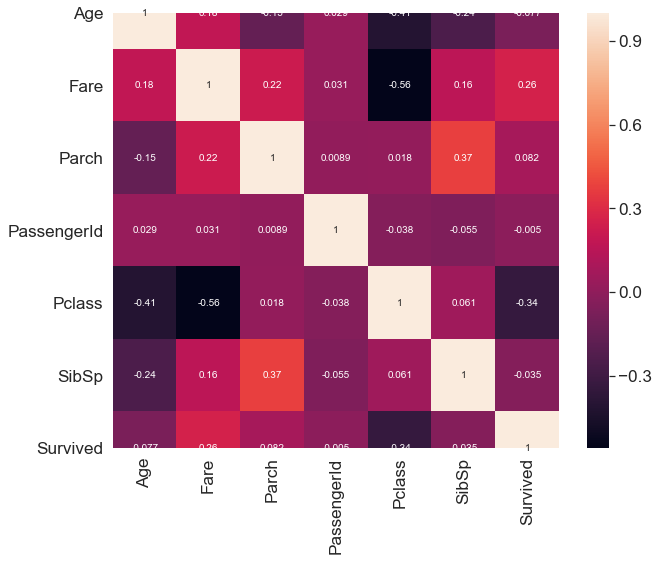

In [12]:
#使用seaborn的熱度圖觀察表徵之間的線性關聯
plt.figure(figsize=(10, 8))
feature_corr = df_data.corr()
sns.heatmap(feature_corr, annot=True)

,Pclass,Survived
0,1,0.630
1,2,0.473
2,3,0.242


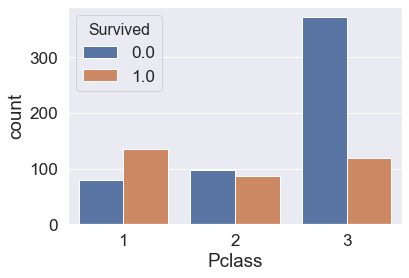

In [11]:
#艙等和生存率的關係
sns.countplot(df_data['Pclass'], hue=df_data['Survived'])
df_data[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().round(3)

,Embarked,Survived
0,C,0.554
1,Q,0.390
2,S,0.337


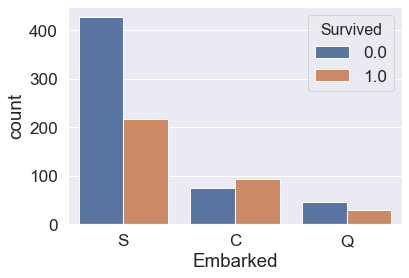

In [14]:
#上船港口和生存率的關係
sns.countplot(df_data['Embarked'], hue=df_data['Survived'])
df_data[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().round(3)

,Sex,Survived
0,female,0.742
1,male,0.189


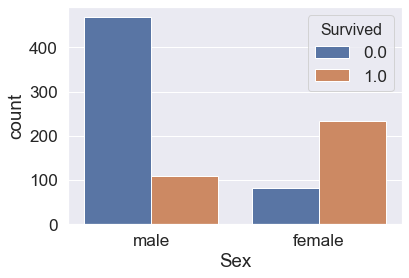

In [15]:
#性別和生存率的關係
sns.countplot(df_data['Sex'], hue=df_data['Survived'])
display(df_data[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().round(3))

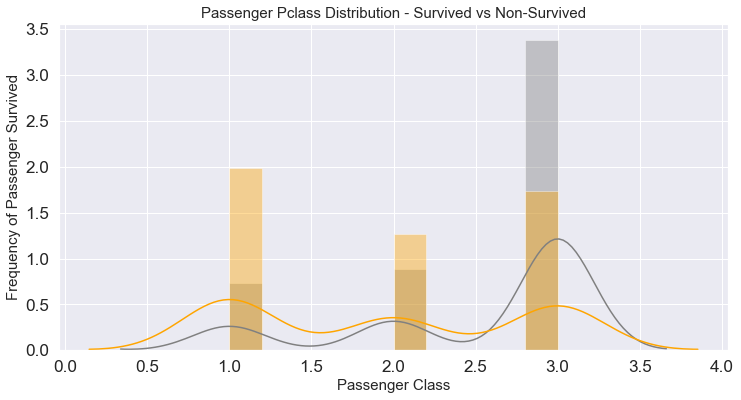

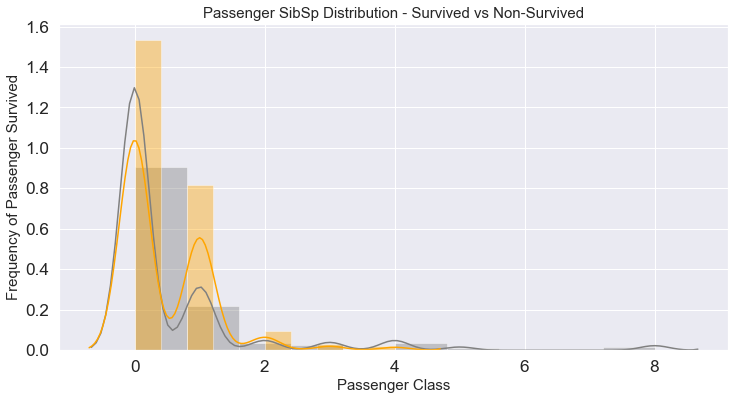

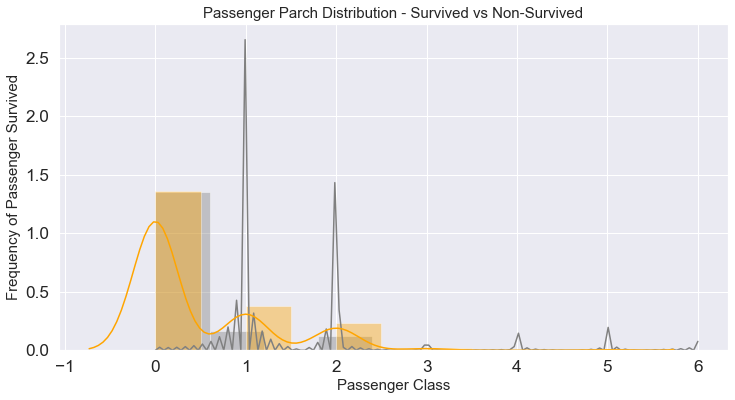

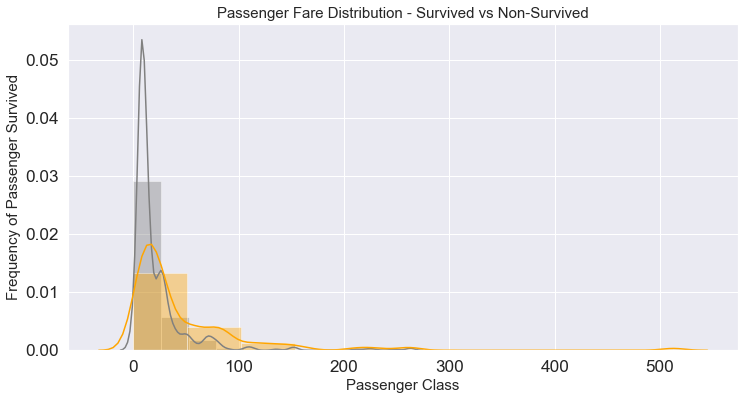

In [18]:
#比對生存以及死亡的乘客在各表徵的數量
for col in ['Pclass',
            'SibSp', #鐵達尼號上的兄弟姊妹/配偶數量
            'Parch', #鐵達尼號上的雙親/子女數量
            'Fare']:

    fig = plt.figure(figsize=(12,6),)
    sns.distplot(df_data[df_data.Survived == 0][col],
                 bins=10,
                 color='gray',
                 label='not survived',
                 kde=True)

    sns.distplot(df_data[df_data.Survived == 1][col],
                 bins=10,
                 color='orange',
                 label='survived',
                 kde=True)

    plt.title('Passenger {} Distribution - Survived vs Non-Survived'.format(col), fontsize = 15)
    plt.ylabel("Frequency of Passenger Survived", fontsize = 15)
    plt.xlabel("Passenger Class", fontsize = 15)


Summary:

透過EDA，我們很快觀察到資料集中與乘客存活率相關聯的重要表徵，例如:乘客等級越高的生存率相對較高、女生存活機率遠高於男性、從C港口上船的旅客有較高的存活率...等等。


In [49]:
#類別變數轉換-性別
df_data['Sex_Code'] = df_data['Sex'].map({'female' : 1, 'male' : 0}).astype('int')

In [ ]:
#先用目前的處理進行初步模型試運，產出 baseline

In [50]:
#分割訓練資料與測試資料
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

In [51]:
df_train.shape

(891, 13)

In [52]:
df_test.shape

(418, 13)

In [53]:
#定義特徵變數與目標變數
X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

In [54]:
X.shape

(891, 11)

In [55]:
len(Y)

891

In [56]:
Base = ['Sex_Code','Pclass']
Base_Model = RandomForestClassifier(random_state=2,
                                    n_estimators=250, #幾棵樹
                                    min_samples_split=20,
                                    oob_score=True)

In [57]:
Base_Model.fit(X[Base] , Y)
print('Base oob score :%.5f' %(Base_Model.oob_score_))


Base oob score :0.73176



僅用性別和艙等作為模型訓練資料，在OOB上獲得0.73176的準確率，這是一個基準值!

再深入探討，看能不能再提高模型表現~~

特徵工程:

1.)補缺值

2.)做新特徵

3.)正規化


In [ ]:
#STEP4:特徵工程之一，補遺失值

In [58]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
Sex_Code       1309 non-null int32
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 138.1+ KB


In [59]:
#票價只有一個遺失值
# Filling missing values
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())


Sex,female,male,All
Has_Age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


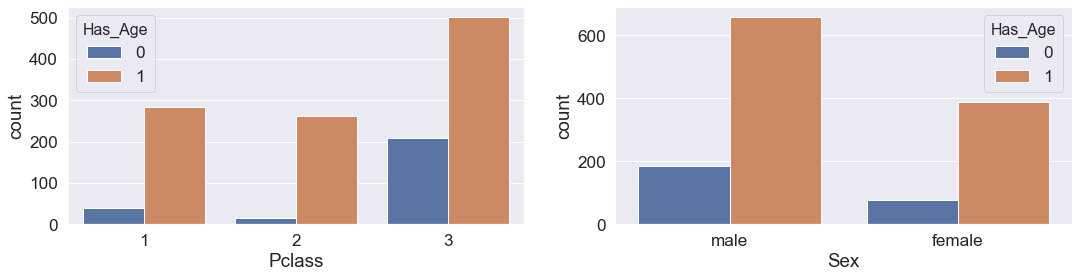

In [60]:
#觀察年齡遺失值分布情況

df_data['Has_Age'] = df_data['Age'].isnull().map(lambda x : 0 if x == True else 1)

fig, [ax1, ax2] = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1 = sns.countplot(df_data['Pclass'],hue=df_data['Has_Age'],ax=ax1)
ax2 = sns.countplot(df_data['Sex'],hue=df_data['Has_Age'],ax=ax2)

pd.crosstab(df_data['Has_Age'],df_data['Sex'],margins=True).round(3)

Text(0.5, 1.0, 'Age vs Survived in Pclass = 1 and  2')

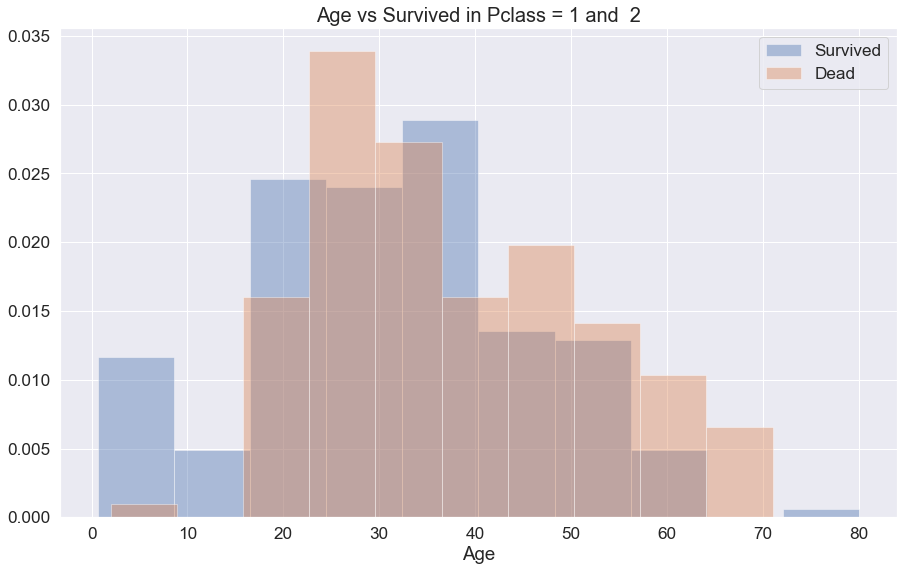

In [61]:
#1,2艙之中，年齡對存活與否的影響

# Masks
Mask_Has_Age_P12_Survived = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 1) )
Mask_Has_Age_P12_Dead = ( (df_data.Has_Age == 1) & (df_data.Pclass != 3 ) & (df_data.Survived == 0) )

# Plot
fig, ax = plt.subplots( figsize = (15,9) )
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Survived, 'Age'],kde=False,bins=10,norm_hist=True,label='Survived') 
ax = sns.distplot(df_data.loc[Mask_Has_Age_P12_Dead, 'Age'],kde=False,bins=10,norm_hist=True,label='Dead')
ax.legend()
ax.set_title('Age vs Survived in Pclass = 1 and  2',fontsize = 20)

年齡這個特徵可以抽取出<16歲及>16歲做為一個二元特徵

In [62]:
# extracted title using name
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_data['Title'] = df_data['Title'].replace(['Capt', 'Col', 'Countess', 'Don',
                                               'Dr', 'Dona', 'Jonkheer', 
                                                'Major','Rev','Sir'],'Rare') 
df_data['Title'] = df_data['Title'].replace(['Mlle', 'Ms','Mme'],'Miss')
df_data['Title'] = df_data['Title'].replace(['Lady'],'Mrs')
df_data['Title'] = df_data['Title'].map({"Mr":0, "Rare" : 1, "Master" : 2,"Miss" : 3, "Mrs" : 4 })


In [63]:
#填入缺失值的方式我們選擇使用姓名當中的稱謂中位數來填補
Ti = df_data.groupby('Title')['Age'].median()
Ti

Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

列表為年齡中位數:

先生 - 29歲

罕見稱謂 - 47歲

小男孩 - 4歲

小姐- 22歲

女士 - 36歲

In [64]:
#創建Ti_Age，分為<16歲及>16歲，命名為Ti_Minor

Ti_pred = df_data.groupby('Title')['Age'].median().values
df_data['Ti_Age'] = df_data['Age']

# Filling the missing age
for i in range(0,5):
    df_data.loc[(df_data.Age.isnull()) & (df_data.Title == i),'Ti_Age'] = Ti_pred[i]

df_data['Ti_Age'] = df_data['Ti_Age'].astype('int')

df_data['Ti_Minor'] = ((df_data['Ti_Age']) < 16.0) * 1

In [73]:
#看一下目前做特徵工程對模型表現的改善程度:

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.79349


比baseline大幅增加0.06!再接再厲~~

In [74]:
#STEP4:特徵工程之二，產生新特徵

In [75]:
#嘗試測試看看'票價'此一特徵
#將票價分別切分成4,5,6的區間
#qcut以累積百分比來切分
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)


In [76]:
label = LabelEncoder() #標籤編碼
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])

In [77]:
df_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Has_Age,Title,Ti_Age,Ti_Minor,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,...,1,0,22,0,"(-0.001, 7.896]","(-0.001, 7.854]","(-0.001, 7.775]",0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,...,1,4,38,0,"(31.275, 512.329]","(41.579, 512.329]","(53.1, 512.329]",3,4,5
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,...,1,3,26,0,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,...,1,4,35,0,"(31.275, 512.329]","(41.579, 512.329]","(26.0, 53.1]",3,4,4
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,...,1,0,35,0,"(7.896, 14.454]","(7.854, 10.5]","(7.775, 8.662]",1,1,1


In [78]:
# cross tab
df_4 = pd.crosstab(df_data['FareBin_Code_4'],df_data['Pclass'])
df_5 = pd.crosstab(df_data['FareBin_Code_5'],df_data['Pclass'])
df_6 = pd.crosstab(df_data['FareBin_Code_6'],df_data['Pclass'])

display_side_by_side(df_4,df_5,df_6)

Pclass,1,2,3
FareBin_Code_4,,,
0,8,6,323
1,0,128,193
2,77,104,147
3,238,39,46
Pclass,1,2,3
FareBin_Code_5,,,
0,8,6,261
1,0,36,218
2,0,124,132


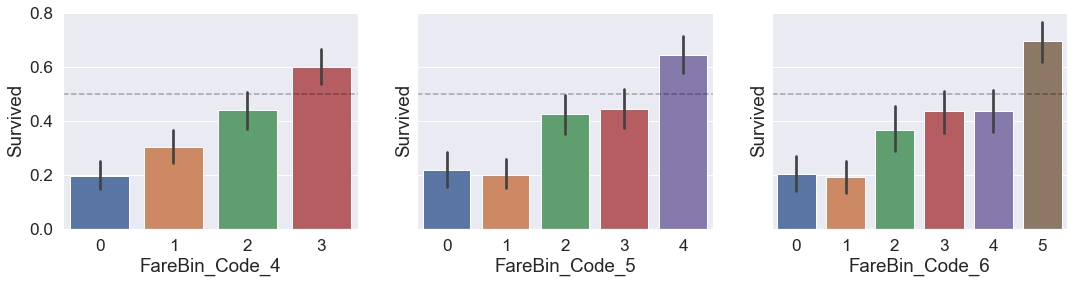

In [79]:
# plots
fig, [ax1, ax2, ax3] = plt.subplots(1, 3,sharey=True)

fig.set_figwidth(18)

for axi in [ax1, ax2, ax3]:
    axi.axhline(0.5,linestyle='dashed', c='black',alpha = .3)
g1 = sns.factorplot(x='FareBin_Code_4', y="Survived", data=df_data,kind='bar',ax=ax1)
g2 = sns.factorplot(x='FareBin_Code_5', y="Survived", data=df_data,kind='bar',ax=ax2)
g3 = sns.factorplot(x='FareBin_Code_6', y="Survived", data=df_data,kind='bar',ax=ax3)

# close FacetGrid object
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

#生存率 vs 票價區間，分別切成4, 5, 6個區間，上下的黑線為95%信賴區間
#圖中虛線表示為機器隨機亂猜，應該要有50%的準確率

In [80]:
#看一下目前做特徵工程對模型表現的改善程度:

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor','FareBin_Code_4','FareBin_Code_5','FareBin_Code_6']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.81257


從0.79349 >> 0.81257!

In [81]:
# Family_size
#兄弟姊妹數SibSp+父母小孩數Parch+1
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [82]:
#再看一下目前做特徵工程對模型表現的改善程度:

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor','Family_size']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.82267


Family_size這是一個超強的特徵組合!


In [83]:
#建立持有相同票根的DataFrame

deplicate_ticket = []

for tk in df_data.Ticket.unique():
    
    tem = df_data.loc[df_data.Ticket == tk, 'Fare']
    #print(tem)
    
    if tem.count() > 1:
        deplicate_ticket.append(df_data.loc[df_data.Ticket == tk,['Name','Ticket','Fare','Cabin','Family_size','Survived']])

        
deplicate_ticket = pd.concat(deplicate_ticket)

deplicate_ticket.head(10)

,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
234,"Cumings, Mr. John Bradley",PC 17599,71.2833,C85,2,NaN
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
146,"Hilliard, Mr. Herbert Henry",17463,51.8625,E46,1,NaN
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


In [84]:
# Family_size = 1 但是又在群組內的，即非親屬關係，我們歸類為朋友
# Family_size > 1則為家人

df_fri = deplicate_ticket.loc[(deplicate_ticket.Family_size == 1) & (deplicate_ticket.Survived.notnull())].head(7)
df_fami = deplicate_ticket.loc[(deplicate_ticket.Family_size > 1) & (deplicate_ticket.Survived.notnull())].head(7)

display(df_fri,df_fami)

print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print('friends: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size == 1]))
print('families: %.0f '%len(deplicate_ticket[deplicate_ticket.Family_size > 1]))

,Name,Ticket,Fare,Cabin,Family_size,Survived
6,"McCarthy, Mr. Timothy J",17463,51.8625,E46,1,0.0
20,"Fynney, Mr. Joseph J",239865,26.0000,NaN,1,0.0
791,"Gaskell, Mr. Alfred",239865,26.0000,NaN,1,0.0
195,"Lurette, Miss. Elise",PC 17569,146.5208,B80,1,1.0
681,"Hassab, Mr. Hammad",PC 17572,76.7292,D49,1,1.0
61,"Icard, Miss. Amelie",113572,80.0000,B28,1,1.0
829,"Stone, Mrs. George Nelson (Martha Evelyn)",113572,80.0000,B28,1,1.0


,Name,Ticket,Fare,Cabin,Family_size,Survived
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599,71.2833,C85,2,1.0
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803,53.1000,C123,2,1.0
137,"Futrelle, Mr. Jacques Heath",113803,53.1000,C123,2,0.0
7,"Palsson, Master. Gosta Leonard",349909,21.0750,NaN,5,0.0
24,"Palsson, Miss. Torborg Danira",349909,21.0750,NaN,5,0.0
374,"Palsson, Miss. Stina Viola",349909,21.0750,NaN,5,0.0
567,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",349909,21.0750,NaN,5,0.0


people keep the same ticket: 596 
friends: 127 
families: 469 


In [85]:
df_data['Connected_Survival'] = 0.5   #沒有生還資訊，定義Connected_Survival = 0.5 

for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):  #過濾出重複的票根
        for ind, row in df_grp.iterrows():
            smax = df_grp.drop(ind)['Survived'].max()
            smin = df_grp.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):  #如果群組中有人生還，則定義 Connected_Survival = 1
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):  #沒有人生還，則定義Connected_Survival = 0
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0

                
print('people keep the same ticket: %.0f '%len(deplicate_ticket))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))

df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


,Survived
Connected_Survival,
0.0,0.225
0.5,0.298
1.0,0.728


In [139]:
#再看一下目前做特徵工程對模型表現的改善程度:

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor','Family_size','Connected_Survival']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.84287



再提升到了0.8428!!


In [143]:
minor = ['Sex_Code','Pclass','Ti_Minor','Family_size','Connected_Survival']
X_test = pd.get_dummies(df_test[minor])
predictions = minor_Model.predict(X_test)
predictions

array([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1.


是否還能透過Cabin欄位去提升模型表現?


In [93]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 25 columns):
Age                   1046 non-null float64
Cabin                 295 non-null object
Embarked              1307 non-null object
Fare                  1309 non-null float64
Name                  1309 non-null object
Parch                 1309 non-null int64
PassengerId           1309 non-null int64
Pclass                1309 non-null int64
Sex                   1309 non-null object
SibSp                 1309 non-null int64
Survived              891 non-null float64
Ticket                1309 non-null object
Sex_Code              1309 non-null int32
Has_Age               1309 non-null int64
Title                 1309 non-null int64
Ti_Age                1309 non-null int32
Ti_Minor              1309 non-null int32
FareBin_4             1309 non-null category
FareBin_5             1309 non-null category
FareBin_6             1309 non-null category
FareBin_Code_4        1309 non-null 

In [119]:
cabin_missingValue_index = df_data['Cabin'].isna().index
cabin_missingValue_index 

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            408, 409, 410, 411, 412, 413, 414, 415, 416, 417],
           dtype='int64', length=1309)

In [102]:
df_data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [111]:
#將name欄位做字串的處理，取得名字的first name
df_data['first name'] = df_data['Name'].apply(lambda x:x.split(",")[0])
df_data['first name'] 

0             Braund
1            Cumings
2          Heikkinen
3           Futrelle
4              Allen
           ...      
413          Spector
414    Oliva y Ocana
415          Saether
416             Ware
417            Peter
Name: first name, Length: 1309, dtype: object

In [113]:
df_data['first name'].value_counts().head(20)

Sage         11
Andersson    11
Asplund       8
Goodwin       8
Davies        7
Brown         6
Rice          6
Smith         6
Skoog         6
Johnson       6
Ford          6
Carter        6
Fortune       6
Panula        6
Palsson       5
Ryerson       5
Thomas        5
Kelly         5
Lefebre       5
Williams      5
Name: first name, dtype: int64

重複的first name可真多，動念一想，會不會有著相同的first name的乘客是同一家族的人呢?

試以first name為Panula的乘客來看看:

In [114]:
df_data[df_data['first name']=='Panula']

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Ti_Minor,FareBin_4,FareBin_5,FareBin_6,FareBin_Code_4,FareBin_Code_5,FareBin_Code_6,Family_size,Connected_Survival,first name
50,7.0,NaN,S,39.6875,"Panula, Master. Juha Niilo",1,51,3,male,4,...,1,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula
164,1.0,NaN,S,39.6875,"Panula, Master. Eino Viljami",1,165,3,male,4,...,1,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula
266,16.0,NaN,S,39.6875,"Panula, Mr. Ernesti Arvid",1,267,3,male,4,...,0,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula
638,41.0,NaN,S,39.6875,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,639,3,female,0,...,0,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula
686,14.0,NaN,S,39.6875,"Panula, Mr. Jaako Arnold",1,687,3,male,4,...,1,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula
824,2.0,NaN,S,39.6875,"Panula, Master. Urho Abraham",1,825,3,male,4,...,1,"(31.275, 512.329]","(21.558, 41.579]","(26.0, 53.1]",3,3,4,6,0.0,Panula


In [115]:
#highlight部分:
cols = ['Age','Cabin','Embarked','Fare','Name','Parch','Pclass','SibSp','Ticket']
df_data[df_data['first name']=='Panula'][cols]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,SibSp,Ticket
50,7.0,NaN,S,39.6875,"Panula, Master. Juha Niilo",1,3,4,3101295
164,1.0,NaN,S,39.6875,"Panula, Master. Eino Viljami",1,3,4,3101295
266,16.0,NaN,S,39.6875,"Panula, Mr. Ernesti Arvid",1,3,4,3101295
638,41.0,NaN,S,39.6875,"Panula, Mrs. Juha (Maria Emilia Ojala)",5,3,0,3101295
686,14.0,NaN,S,39.6875,"Panula, Mr. Jaako Arnold",1,3,4,3101295
824,2.0,NaN,S,39.6875,"Panula, Master. Urho Abraham",1,3,4,3101295


這些人在上船的港口、票價、艙等級、親人數量，重點在票別完全一樣。

甚者，有5位乘客都是手足(兄弟姊妹)數量為4、雙親/子女數量為1；如果一次看一名乘客的話，剩下的4人正好是他手足的數量。

言下之意，這五名乘客互為彼此的兄弟姊妹；而親人數量為5的那位，不就是他們的媽媽嗎XDD


In [117]:
#這下可以來補 Cabin的遺失值了~~

ticket_valueCounts = []
for i in df_data['Ticket']:
    if i not in ticket_valueCounts:
        ticket_valueCounts.append(i)
        
#print(ticket_valueCounts)


In [122]:
for i in df_data.iloc[cabin_missingValue_index]:
    df_data['Cabin'] = df_data['Ticket']
    
df_data['Cabin'].isna().value_counts()

False    1309
Name: Cabin, dtype: int64

In [124]:
label = LabelEncoder() #標籤編碼
df_data['Cabin'] = label.fit_transform(df_data['Cabin'])
df_data['Cabin'].value_counts()

778    11
104     8
775     8
847     7
824     7
       ..
531     1
530     1
529     1
528     1
422     1
Name: Cabin, Length: 929, dtype: int64

In [126]:
df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor','Family_size','Connected_Survival']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))

minor oob score :0.84287


In [138]:
#看一下目前做特徵工程對模型表現的改善程度:

df_train = df_data[:len(df_train)]
df_test = df_data[len(df_train):]

X = df_train.drop(labels=['Survived','PassengerId'],axis=1)
Y = df_train['Survived']

minor = ['Sex_Code','Pclass','Ti_Minor','Family_size','Connected_Survival','Cabin']
minor_Model = RandomForestClassifier(
    random_state=2,
    n_estimators=250,
    min_samples_split=20,
    oob_score=True)

minor_Model.fit(X[minor], Y)

print('minor oob score :%.5f' %(minor_Model.oob_score_))


minor oob score :0.81369


@@......看樣子Cabin(船艙編號)變數對解釋生存率本身效果就有限，這似乎也能理解，畢竟艙等比較有關連性

In [149]:
#最後統整上傳到Kaggle:

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': predictions.astype(int)})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")
output  

Your submission was successfully saved!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [150]:
submission_df = pd.read_csv('C:/Users/USER/Desktop/Github/Python Project/my_submission.csv')
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
